# The Timeseries Quantum Autoencoder
*TS QAE in Qiskit with angle encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - March 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Several approaches to TS data encoding were tested, i.e. unary, binary and anglular.
- Angle encoding was eventually used, with values centered around H state, in the range of [-pi/2..pi/2]
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021
3. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
4. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
5. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
6. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')
sys.path

['/home/jacob/miniconda3/envs/qiskit_qae/lib/python310.zip',
 '/home/jacob/miniconda3/envs/qiskit_qae/lib/python3.10',
 '/home/jacob/miniconda3/envs/qiskit_qae/lib/python3.10/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit_qae/lib/python3.10/site-packages',
 '.',
 '..',
 '../..',
 '../../..']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
import copy
import os.path as path

from IPython.display import clear_output

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *
from utils.Charts import *
from utils.Integrate import *
from utils.Circuits import *
from utils.Angles import *
from utils.Files import *
from utils.Cost import *
from utils.Metrics import *

import torch
from torch import nn, tensor, optim
from torch.utils.data import DataLoader, Dataset
# from torchviz import make_dot

from matplotlib import set_loglevel
set_loglevel("error")
%matplotlib inline

## Load dataset hyper-parameters

In [4]:
### Constants
LOG_NAME = 'beer_xtest'
CASE_NAME = '2step_torch'
DATA_NAME = 'beer_2step'
DATA_PATH = f'{LOG_NAME}/data'
TRAIN_PATH = f'{LOG_NAME}/training'
PARAMS_PATH = f'{LOG_NAME}/params'
ANALYSIS_PATH = f'{LOG_NAME}/analysis'
SCORES_PATH = f'{LOG_NAME}/scores'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Show constants
(LOG_NAME, CASE_NAME, DATA_NAME,DATA_PATH, TRAIN_PATH, PARAMS_PATH, ANALYSIS_PATH, SCORES_PATH, FIGURES_PATH)

('beer_xtest',
 '2step_torch',
 'beer_2step',
 'beer_xtest/data',
 'beer_xtest/training',
 'beer_xtest/params',
 'beer_xtest/analysis',
 'beer_xtest/scores',
 'beer_xtest/figures')

In [5]:
### Load repository info
data_info_path = f'{DATA_PATH}/beer_2step_n200_w8_ws2_z0.03_zr1_info.json'
data_info = read_json_file(data_info_path)
data_info

{'case_name': 'beer_2step',
 'major_version': 4,
 'minor_version': 0,
 'samples': 200,
 'split': 0.75,
 'wind_size': 8,
 'wind_step': 2,
 'horizon': 1,
 'scale': 1,
 'pan': 0,
 'noise': 0.03,
 'noise_reps': 1}

In [6]:
### Load all data hyper-parameters

# Software version
major_version = data_info['major_version']
minor_version = data_info['minor_version']

# Data settings
samples = data_info['samples']
split = data_info['split']
wind_size = data_info['wind_size']
wind_step = data_info['wind_step']
horizon = data_info['horizon']
scale = data_info['scale']
pan = data_info['pan']

# Noise level
noise = data_info['noise']
noise_reps = data_info['noise_reps']

In [7]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
DATA_PREF = f'{DATA_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}'
DATA_PREF

'beer_2step_n200_w8_ws2_z0.03_zr1'

## Load training hyper-parameters

In [8]:
# train_info_default_fpath = f'{TRAIN_PATH}/info.json'
train_info_default_fpath = f'{TRAIN_PATH}/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_info.json'
train_info = read_json_file(train_info_default_fpath)
train_info

{'case_name': '2step_torch',
 'major_version': 4,
 'minor_version': 0,
 'reps': 0,
 'ent': 'none',
 'rot_block': 'none',
 'num_qubits': 8,
 'num_trash': 1,
 'num_latent': 7,
 'added_width': 0,
 'cost_type': 'L1',
 'cost_yscale': 'linear',
 'shuffle_interv': 0,
 'log_interv': 100,
 'epochs': 30000,
 'shots': 0,
 'seed': 2024}

In [9]:
reps = train_info['reps']
ent = train_info['ent']
rot_block = train_info['rot_block']
num_qubits = train_info['num_qubits']
num_trash = train_info['num_trash']
num_latent = train_info['num_latent']
added_width = train_info['added_width']
shuffle_interv = train_info['shuffle_interv']
log_interv = train_info['log_interv']
cost_type = train_info['cost_type']
cost_yscale = train_info['cost_yscale']
epochs = train_info['epochs'] 
shots = train_info['shots']
seed = train_info['seed']

## Load the necessary files

In [10]:
### All data files

y_train_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_org.arr'
y_valid_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_org.arr'
y_train_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_org.arr'
y_valid_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_org.arr'

y_train_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_ts.arr'
y_train_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_ts.arr'
y_valid_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_ts.arr'

y_train_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_enc.arr'
y_valid_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_enc.arr'
y_train_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_enc.arr'
y_valid_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_enc.arr'

data_info_fpath = f'{DATA_PATH}/{DATA_PREF}_info.json'
data_info_fpath

'beer_xtest/data/beer_2step_n200_w8_ws2_z0.03_zr1_info.json'

In [11]:
### Load the necessary data and reshape as necessary

y_train_enc = read_ts_file(y_train_enc_fpath)
y_valid_enc = read_ts_file(y_valid_enc_fpath)

y_train_noisy_enc = read_ts_file(y_train_noisy_enc_fpath).reshape(noise_reps, y_train_enc.shape[0], y_train_enc.shape[1])
y_valid_noisy_enc = read_ts_file(y_valid_noisy_enc_fpath).reshape(noise_reps, y_valid_enc.shape[0], y_valid_enc.shape[1])

In [12]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
TRAIN_PREF = f'{CASE_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}_reps{reps}_aw{added_width}_{ent}_lat{num_latent}'
TRAIN_PREF

'2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7'

In [13]:
### All training files
train_info_default_fpath = f'{TRAIN_PATH}/info.json'
train_info_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_info.json'
init_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_init.json'
history_fpath = f'{TRAIN_PATH}/{TRAIN_PREF}_hist{epochs}.json'
params_fpath = f'{PARAMS_PATH}/{TRAIN_PREF}_params.json'
train_info_fpath

'beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_info.json'

In [14]:
### Load some necessary files and reshape data as necessary
optimum_parameters = torch.load(f'{init_fpath}')
print(f'\nLoaded the optimum parameters as the future starting point from:\n\t{init_fpath}')

history = read_json_file(f'{history_fpath}')
print(f'Loaded the loss history from:\n\t{history_fpath}')

### Load info on the history of the model parameters
params_parent_fpath = path.abspath(os.path.join(params_fpath, os.pardir))
param_info = read_json_file(f'{params_fpath[:-5]}_info{params_fpath[-5:]}')
log_interv = param_info['log_interv'] # Reloaded in case any changes occurred
log_number = param_info['log_number']

hist_params = []
for next_params_no in range(log_number):
    next_param_pname = f'{params_fpath[:-5]}_{next_params_no:04d}{params_fpath[-5:]}'
    hist_params.append(torch.load(f'{next_param_pname}'))
print(f'Loaded {log_number} optimisation parameters from files:\n\t{params_fpath[:-5]}_xxxx{params_fpath[-5:]}\n')

param_info


Loaded the optimum parameters as the future starting point from:
	beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_init.json
Loaded the loss history from:
	beer_xtest/training/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_hist30000.json
Loaded 300 optimisation parameters from files:
	beer_xtest/params/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_params_xxxx.json



{'case_name': '2step_torch',
 'major_version': 4,
 'minor_version': 0,
 'log_interv': 100,
 'log_number': 300}

## Prepare settings for the analysis and saving results

In [15]:
train_inorg_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_torg.json'
train_inmeas_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_tinm.json'
train_outrec_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_tout.json'
valid_inorg_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_vorg.json'
valid_inmeas_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_vinm.json'
valid_outrec_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_vout.json'
tmae_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_tmae{epochs}.json'
vmae_fpath = f'{ANALYSIS_PATH}/{TRAIN_PREF}_vmae{epochs}.json'
tmae_fpath

'beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_tmae30000.json'

## Plot files ready for the analysis



TS noise = 3.0%, calculated noise in differenced TS = 2.7%, total noise = 63.0641, over the points = 1168



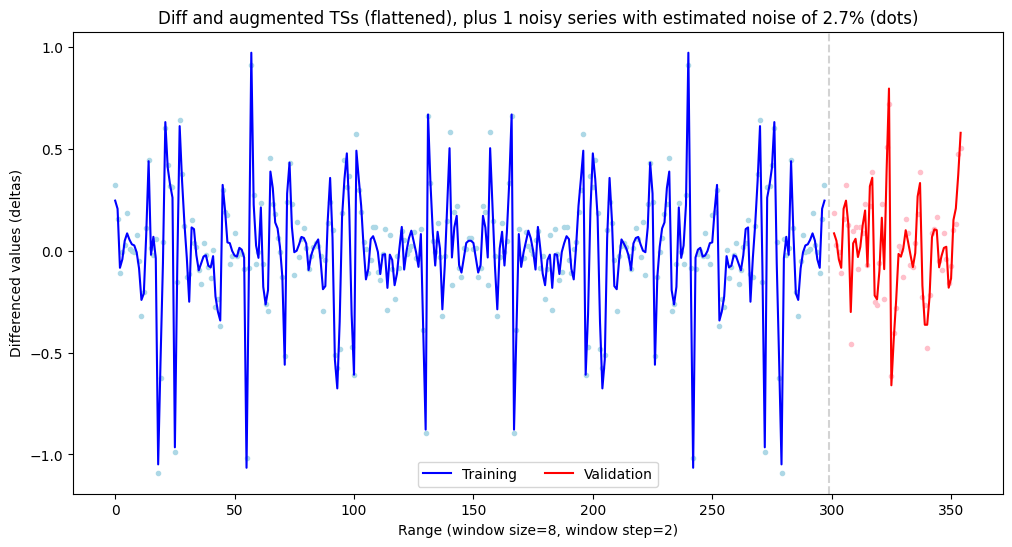

In [16]:
qae_diffaug_plot(y_train_enc, y_valid_enc, y_train_noisy_enc, y_valid_noisy_enc, wind_step, noise, noise_reps,
                 xlabel=f'Range (window size={wind_size}, window step={wind_step})',
                 # line_styles={'train_pure':'dashed', 'train_noisy':'none', 'valid_pure':'solid', 'valid_noisy':'none'},
                 # cols = {'train_pure':'black', 'train_noisy':'lightgray', 'valid_pure':'black', 'valid_noisy':'lightgray'},
                 ylabel='Differenced values (deltas)')

## Analysis of a Quantum Autoencoder

In [17]:
### Libraries used in QAE development

import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

### Pytorch utilities

In [18]:
### Counts the number of pytorch model parameters
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Gets all pytorch parameters
def get_param_vals(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    params = params.cpu().detach().flatten() # [0]
    return params.numpy()

### Defining structures of training and testing models and their components
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

In [19]:
### Simple autoencoder
class Autoencoder(nn.Module):

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(128, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

### Testing the model
def test_with_noise(model, perform_fun, x):

    with torch.no_grad():
        encoded = model.encode(x)
        decoded = model.decode(encoded)

    return decoded, encoded

### Score the model
def score_model(model, score_fun, inp, ref):

    with torch.no_grad():
        encoded = model.encode(inp)
        outp = model.decode(encoded)
        inp_arr = inp.cpu().detach().numpy()
        outp_arr = outp.cpu().detach().numpy()
        ref_arr = ref.cpu().detach().numpy()
        score = score_fun(outp_arr, ref_arr)

    return score

### Determine device to test the model

In [20]:
### Find what devices are available
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

### Prepare data for torch use

In [21]:
y_train_tens = torch.from_numpy(y_train_enc).to(device)
y_valid_tens = torch.from_numpy(y_valid_enc).to(device)
y_train_noisy_tens = torch.from_numpy(y_train_noisy_enc).to(device)
y_valid_noisy_tens = torch.from_numpy(y_valid_noisy_enc).to(device)

### Create a model

In [22]:
### Set random seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
cae = Autoencoder(in_shape=wind_size, enc_shape=num_latent).double().to(device)
cae.load_state_dict(optimum_parameters)

### Loss and optimiser

# error = nn.MSELoss()
error = nn.L1Loss()

# optimizer=optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# optimizer = optim.Adam(cae.parameters())

### Show 
cae.eval()

Autoencoder(
  (encode): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=7, bias=True)
  )
  (decode): Sequential(
    (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=7, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=128, out_features=8, bias=True)
  )
)

In [23]:
# Models structures

print(f'Encoder characteristics: \n\n'+
      f'\ttraining windows={len(y_train_enc)}\n'+
      f'\tvalidation windows={len(y_valid_enc)}\n'+
      f'\tinputs={wind_size}\n'+
      f'\tkeep_encoder=N/A\n'+
      f'\tweights={count_params(cae)}\n'+
      f'\ttrash layer={num_trash}\n'+
      f'\tlatent layer={num_latent}\n'+
      f'\treps={reps}\n'+
      f'\tent=N/A\n'+
      f'\tnoise={noise}\n'+
      f'\tnoise repeats={noise_reps}\n'+
      f'\n'+
      f'\tcost type={cost_type}\n'+
      f'\tcost yscale={cost_yscale}\n'+
      f'\tsamples={y_train_enc.shape[0]}\n'+
      f'\tdevice={device}\n'+
      f'\tepochs={epochs}\n'+
      f'\tshots={shots}\n'+
      ''
     )


Encoder characteristics: 

	training windows=146
	validation windows=24
	inputs=8
	keep_encoder=N/A
	weights=19741
	trash layer=1
	latent layer=7
	reps=0
	ent=N/A
	noise=0.03
	noise repeats=1

	cost type=L1
	cost yscale=linear
	samples=146
	device=cuda
	epochs=30000
	shots=0



### Test result scoring

In [24]:
y = merged_flat_tswind(y_train_tens.cpu().detach().numpy(), trim_left=1, trim_right=1)
mape_flat_tswin(y_train_noisy_tens[0].cpu().detach().numpy(), y_train_tens.cpu().detach().numpy(), trim_left=0, trim_right=0)

1.5580100728331991

In [25]:
sel_noise_idx = 0
cae.load_state_dict(hist_params[-1])
r2_score = score_model(cae, lambda x, y: r2_flat_tswin(x, y, trim_left=0, trim_right=0), y_train_noisy_tens[sel_noise_idx], y_train_tens)
rms_score = score_model(cae, lambda x, y: rms_flat_tswin(x, y, trim_left=0, trim_right=0), y_train_noisy_tens[sel_noise_idx], y_train_tens)
mae_score = score_model(cae, lambda x, y: mae_flat_tswin(x, y, trim_left=0, trim_right=0), y_train_noisy_tens[sel_noise_idx], y_train_tens)
print(f'Test scores (noisy vs reconstructed): R2={np.round(r2_score, 4)}, MAE={np.round(mae_score, 4)}, RMS={np.round(rms_score, 4)}')

Test scores (noisy vs reconstructed): R2=0.9784, MAE=0.0247, RMS=0.038


### Test the model

In [26]:
### Select which of the noisy TSs to use
sel_noisy_rec = 0

### Apply test
in_ts = y_train_noisy_tens[sel_noisy_rec][0:3]
out_ts, enc_ts = test_with_noise(cae, error, in_ts)

### Report results
print()
print('Input:\n', in_ts.cpu().detach().numpy(), '\n')
print('Output:\n', out_ts.cpu().detach().numpy(), '\n')


Input:
 [[ 0.32287362  0.15736655 -0.11055673 -0.00741354  0.02812137  0.18581779
   0.00800852 -0.00067542]
 [-0.11055673 -0.00741354  0.02812137  0.18581779  0.00800852 -0.00067542
  -0.00350593  0.07838433]
 [ 0.02812137  0.18581779  0.00800852 -0.00067542 -0.00350593  0.07838433
  -0.04786189 -0.32124213]] 

Output:
 [[ 2.50973258e-01  2.03238001e-01 -5.75512637e-02 -4.48281182e-02
   1.60178577e-02  8.23122844e-02  5.12761930e-02  2.59757298e-02]
 [-8.04881487e-02 -2.90371475e-02  4.33531599e-02  6.05326590e-02
   3.94713271e-02  2.89913262e-02  2.90356722e-02  2.34206350e-04]
 [ 3.68670263e-02  7.58636120e-02  6.21672225e-02  3.68177562e-02
   1.51249399e-02 -1.55408978e-02 -6.50975551e-02 -2.37793239e-01]] 



## Model analysis and testing

### Performance curves with extra details

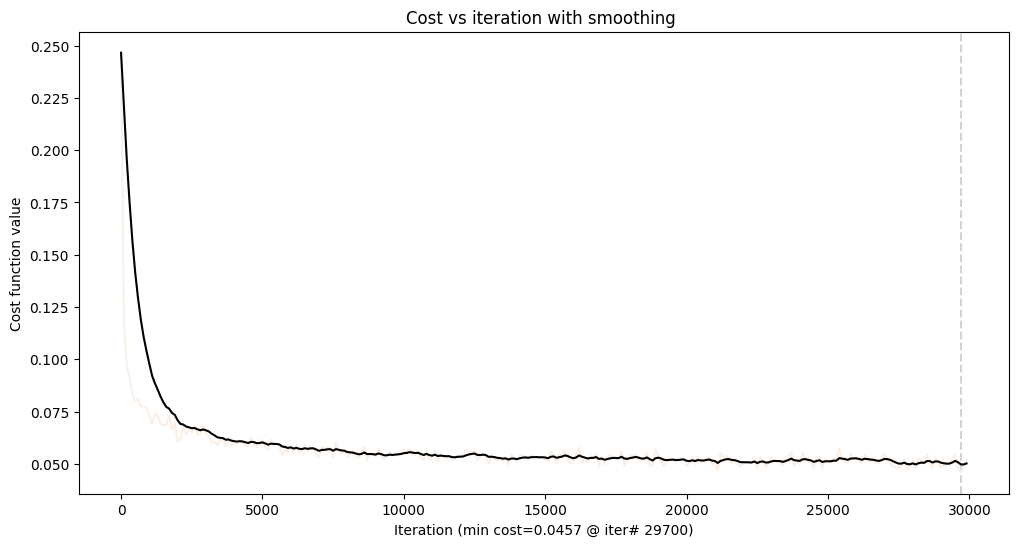

In [27]:
# Colours for background lines = 'linen' 'aliceblue' 'powderblue' 'paleturquoise' 'whitesmoke' 'lightgray' 'antiquewhite'
cost_plot(history, rcParams=(12, 6), smooth_weight=0.8, backplot=True, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_hist{epochs}.eps', log_interv=log_interv)
print()

In [28]:
### Select nosy curve
sel_noise_idx = 0

### Initialise all score curves
r2_train_scores = [];  r2_valid_scores = []
rms_train_scores = []; rms_valid_scores = []
mae_train_scores = []; mae_valid_scores = []

### Collect scores across history
for params_no in range(len(hist_params)):
    cae.load_state_dict(hist_params[params_no])
    
    r2_train_scores.append(score_model(cae, lambda x, y: r2_flat_tswin(x, y, trim_left=0, trim_right=0), y_train_noisy_tens[sel_noise_idx], y_train_tens))
    rms_train_scores.append(score_model(cae, lambda x, y: rms_flat_tswin(x, y, trim_left=0, trim_right=0), y_train_noisy_tens[sel_noise_idx], y_train_tens))
    mae_train_scores.append(score_model(cae, lambda x, y: mae_flat_tswin(x, y, trim_left=0, trim_right=0), y_train_noisy_tens[sel_noise_idx], y_train_tens))  

    r2_valid_scores.append(score_model(cae, lambda x, y: r2_flat_tswin(x, y, trim_left=0, trim_right=0), y_valid_noisy_tens[sel_noise_idx], y_valid_tens))
    rms_valid_scores.append(score_model(cae, lambda x, y: rms_flat_tswin(x, y, trim_left=0, trim_right=0), y_valid_noisy_tens[sel_noise_idx], y_valid_tens))
    mae_valid_scores.append(score_model(cae, lambda x, y: mae_flat_tswin(x, y, trim_left=0, trim_right=0), y_valid_noisy_tens[sel_noise_idx], y_valid_tens))  

### Collect statistics
r2_train_x_of_max = np.argmax(r2_train_scores);   r2_train_max = r2_train_scores[r2_train_x_of_max]
mae_train_x_of_min = np.argmin(mae_train_scores); mae_train_min = mae_train_scores[mae_train_x_of_min]
rms_train_x_of_min = np.argmin(rms_train_scores); rms_train_min = rms_train_scores[rms_train_x_of_min]

r2_valid_x_of_max = np.argmax(r2_valid_scores);   r2_valid_max = r2_valid_scores[r2_valid_x_of_max]
mae_valid_x_of_min = np.argmin(mae_valid_scores); mae_valid_min = mae_valid_scores[mae_valid_x_of_min]
rms_valid_x_of_min = np.argmin(rms_valid_scores); rms_valid_min = rms_valid_scores[rms_valid_x_of_min]

### Select optimum parameters, as per MAE scores
opt_train_params = hist_params[mae_train_x_of_min]
opt_valid_params = hist_params[mae_valid_x_of_min]

In [29]:
print(f'\nTorch model performance as per scores collected at intervals of {log_interv} iterations, over {epochs} epochs')
print(f'\n{"Performance":<10}\tTraining\tValidation\n')

print(f'{"R2":<10}\t{np.round(r2_train_max, 3):<5} @ {r2_train_x_of_max*log_interv}'+
      f'\t{np.round(r2_valid_max, 3):<5} @ {r2_valid_x_of_max*log_interv}')

print(f'{"RMS":<10}\t{np.round(rms_train_min, 3):<5} @ {rms_train_x_of_min*log_interv}'+
      f'\t{np.round(rms_valid_min, 3):<5} @ {rms_valid_x_of_min*log_interv}')

print(f'{"MAE (optimum)":<10}\t{np.round(mae_train_min, 3):<5} @ {mae_train_x_of_min*log_interv}'+
      f'\t{np.round(mae_valid_min, 3):<5} @ {mae_valid_x_of_min*log_interv}')

print()


Torch model performance as per scores collected at intervals of 100 iterations, over 30000 epochs

Performance	Training	Validation

R2        	0.986 @ 23400	0.508 @ 5700
RMS       	0.031 @ 23400	0.124 @ 2200
MAE (optimum)	0.021 @ 25600	0.085 @ 2200



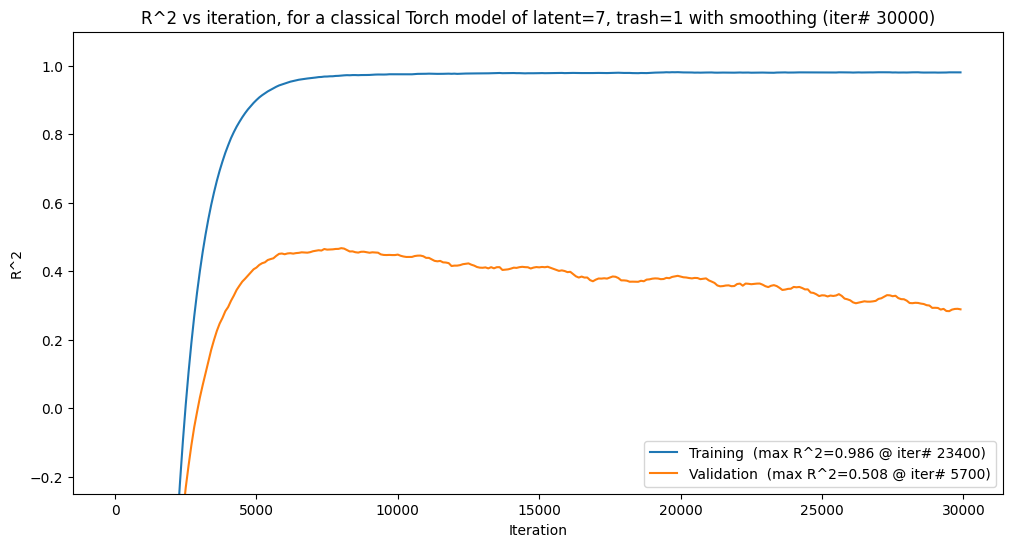

In [30]:
multi_perform_plot([r2_train_scores, r2_valid_scores], rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_r2{epochs}.eps',
                  title=f'R^2 vs iteration, for a classical Torch model of latent={num_latent}, trash={num_trash}', meas_type='R^2', ylim=(-0.25, 1.1),
                  labels=['Training', 'Validation'], meas_min=False, back_color='lightgray', log_interv=log_interv) 

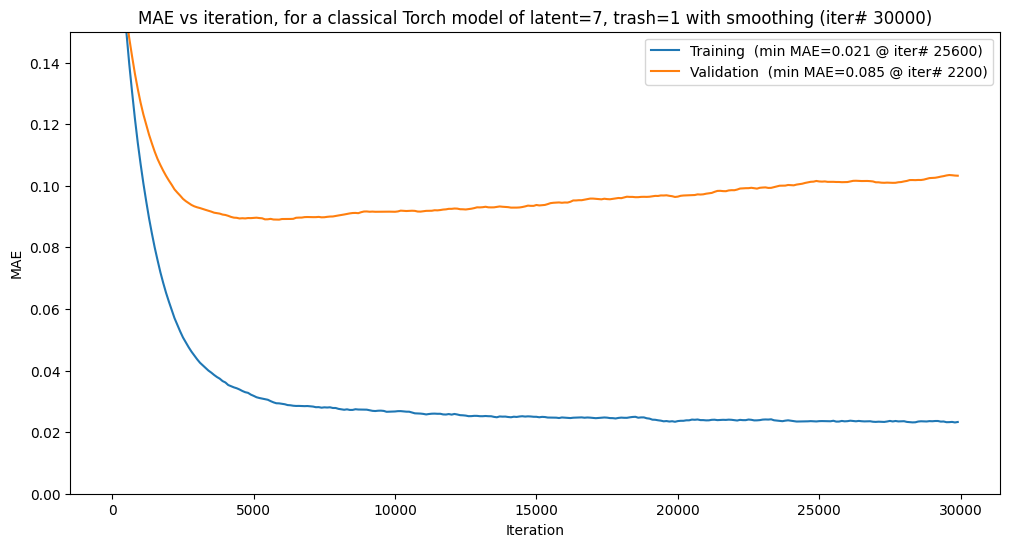

In [31]:
multi_perform_plot([mae_train_scores, mae_valid_scores], rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_mae{epochs}.eps',
                  title=f'MAE vs iteration, for a classical Torch model of latent={num_latent}, trash={num_trash}', meas_type='MAE', ylim=(0, 0.15),
                  labels=['Training', 'Validation'], meas_min=True, back_color='lightgray', log_interv=log_interv)

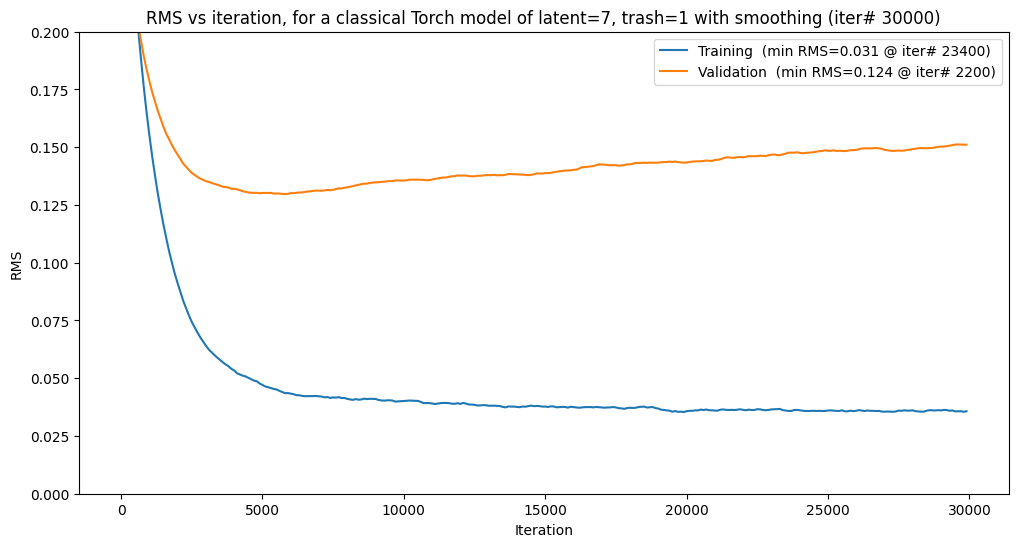

In [32]:
multi_perform_plot([rms_train_scores, rms_valid_scores], rcParams=(12, 6), yscale='linear', # yscale='log'
                  backplot=False, smooth_weight=0.9, save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_rms{epochs}.eps',
                  title=f'RMS vs iteration, for a classical Torch model of latent={num_latent}, trash={num_trash}', meas_type='RMS', ylim=(0, 0.2),
                  labels=['Training', 'Validation'], meas_min=True, back_color='lightgray', log_interv=log_interv)

### QAE calculation and analysis of the selected TS windows

In [33]:
### Select a collection of windows to test

# sel_wind_train_set = random.sample(range(0, len(y_train_enc)), 20)
# sel_wind_valid_set = random.sample(range(0, len(y_valid_enc)), 20)
sel_wind_train_set = [*range(38, 58, 1)] # [*range(len(y_train_enc))]
sel_wind_valid_set = [*range(len(y_valid_enc))]

print(f'Selected {len(sel_wind_train_set)} training windows:\t{sel_wind_train_set}')
print(f'Selected {len(sel_wind_valid_set)} validation windows:\t{sel_wind_valid_set}')

Selected 20 training windows:	[38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]
Selected 24 validation windows:	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [34]:
### Generation of QAE results for the selected windows

### Analyses a sample of windows, QAE(in) -> recons
### winds_pure: a list/array of TS windows
### sel_wind_set: a list of the selected windows indeces
### returns: dictionaries of a subset of original, measured, and reconstructured windows
###          the keys correspond to windows sequence position in a TS

def qae_analyse_sample(sel_wind_set, winds_pure, winds_noise, error=nn.L1Loss(), device='cuda', wind_step=1, opt_params=None):
    print(f'Processed windows: ', end=' ')

    in_org_set = {}
    in_meas_set = {}
    out_reconstr_set = {}

    for wind_idx in range(len(sel_wind_set)):
    
        sel_wind = sel_wind_set[wind_idx]

        ### Add pure window for reference
        in_org_set[sel_wind*wind_step] = list(winds_pure[sel_wind]) 
    
        ### The "measured" input is just a noisy window
        in_meas_set[sel_wind*wind_step] = list(winds_noise[sel_wind])
    
        ### Apply QAE to windows and return reconstructed window
        in_ts = torch.from_numpy(np.array([list(winds_noise[sel_wind])])).to(device)
        if opt_params is not None: cae.load_state_dict(opt_params)
        out_ts, _ = test_with_noise(cae, error, in_ts)
        out_reconstr_set[sel_wind*wind_step] = out_ts.cpu().detach().tolist()[0] 
    
        print(f'{sel_wind}', end=' ')
    
    print('End\n')
    return in_org_set, in_meas_set, out_reconstr_set

In [35]:
### Analyse samples of training and validation data
sel_noise_set = 0
in_org_train_set, in_meas_train_set, out_reconstr_train_set = \
    qae_analyse_sample(sel_wind_train_set, y_train_enc, y_train_noisy_enc[sel_noise_set], 
                       wind_step=wind_step, error=error, opt_params=opt_train_params) # Noise vs Pure
in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set = \
    qae_analyse_sample(sel_wind_valid_set, y_valid_enc, y_valid_noisy_enc[sel_noise_set], 
                       wind_step=wind_step, error=error, opt_params=opt_valid_params) # Noise vs Pure

Processed windows:  38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 End

Processed windows:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 End



### Reporting of QAE accuracy
Several model performance metrics can be calculated based on the selection of TS windows.<br/>
In the left column we have metrics comparing QAE inputs with the same but quantum measured inputs.<br/>
In the right column we have metrics comparing QAE inputs with its outputs - this is what we are intereted in.<br/>
The left column is for your reference to see the impact of measurement on the QAE precision.

In [36]:
def accuracy_report(in_org_set, in_meas_set, out_reconstr_set, title='Precision of Results',
                   trim_left = 0, trim_right = 0):
    
    print(f'\n{title:<10}\tPure vs Noisy\tPure vs Recovered\n')

    r2_inorg_incalc = r2_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    r2_inorg_outrec = r2_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"R2":<10}\t{np.round(r2_inorg_incalc, 3):<10} '+
          f'\t{np.round(r2_inorg_outrec, 3):<10}')

    rms_inorg_incalc = rms_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    rms_inorg_outrec = rms_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"RMS":<10}\t{np.round(rms_inorg_incalc, 3):<10} '+
          f'\t{np.round(rms_inorg_outrec, 3):<10}')

    mae_inorg_incalc = mae_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    mae_inorg_outrec = mae_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"MAE":<10}\t{np.round(mae_inorg_incalc, 3):<10} '+
          f'\t{np.round(mae_inorg_outrec, 3):<10}')

    mape_inorg_incalc = mape_tswin(in_org_set, in_meas_set, trim_left=trim_left, trim_right=trim_right)
    mape_inorg_outrec = mape_tswin(in_org_set, out_reconstr_set, trim_left=trim_left, trim_right=trim_right)
    print(f'{"MAPE":<10}\t{np.round(mape_inorg_incalc, 3):<10} '+
          f'\t{np.round(mape_inorg_outrec, 3):<10}')

    return mae_inorg_incalc, mae_inorg_outrec

In [37]:
mae_inorg_train_incalc, mae_inorg_train_outrec = \
    accuracy_report(in_org_train_set, in_meas_train_set, out_reconstr_train_set, title='Train. Acc.')
mae_inorg_valid_incalc, mae_inorg_valid_outrec = \
    accuracy_report(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, title='Valid. Acc.')
print()


Train. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.884      	0.986     
RMS       	0.085      	0.03      
MAE       	0.068      	0.021     
MAPE      	3.945      	0.473     

Valid. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.924      	0.741     
RMS       	0.067      	0.124     
MAE       	0.057      	0.085     
MAPE      	1.127      	1.006     



### Ploting sample QAE results
Note the edge distortion, which occurs either at the window's beginning, or more commonly at the end, or both.

In [38]:
### Plot all the selected windows and their recovered data

def qae_plot_winds(in_org_set, in_meas_set, out_reconstr_set, plot_no=None, 
                       xlim=None, ylim=None, rcParams=(12, 6), save_plot=None,
                   title='Original pure data, measured noisy input vs reconstructed pure data',
                   labels=['Original data', 'Noisy input data', 'Reconstructed pure data']):
    
    sorted_keys = sorted(in_org_set.keys())
    if plot_no == None:
        plot_no = len(sorted_keys)
        
    for sel_wind in sorted_keys:

        if plot_no == 0:
            break
    
        # Retrieve window data
        print('\n')
        wind = in_org_set[sel_wind]
        org_meas = in_meas_set[sel_wind]
        out_meas = out_reconstr_set[sel_wind]    
        
        # Plot prepared data
        plt.rcParams["figure.figsize"] = rcParams
        plt.title(f'{title}, within window {sel_wind}')
        plt.xlabel("Data points")
        plt.ylabel("Inter-point differences")
        if xlim is not None: plt.xlim(xlim)
        if ylim is not None: plt.ylim(ylim)

        
        # Plot target function
        plt.plot([x for x in range(len(wind))], wind, color='royalblue', label=labels[0])
        plt.plot([x for x in range(len(wind))], wind, marker='o', color='cornflowerblue', linestyle='None')
        plt.plot([x for x in range(len(wind))], org_meas, color='darkorange', label=labels[1])
        plt.plot([x for x in range(len(wind))], org_meas, marker='o', color='orange', linestyle='None')
        plt.plot([x for x in range(len(wind))], out_meas, color='red', label=labels[2])
        plt.plot([x for x in range(len(wind))], out_meas, marker='o', color='tomato', linestyle='None')
        plt.legend(loc='best', ncol=3)
        if save_plot:
            plt.savefig(f'{save_plot}_{sel_wind:03d}.eps', format='eps')
        plt.show()

        plot_no -= 1
        
    print('\n')

#### Plotting results of analysis performed on training data (previously seen by the full-QAE)
The blue line shows pure data that was given on output during training.</br>
The red curve was reconstructed from the noisy data given on input (not shown here).<br/>
The yellow control curve measures the pure data, it follows the blue curve, the best it can.<br/>
The red curve should follow the blue pure data and its variance should not be much different from the yellow lines,<br/>
as it means it has learnt to recover pure data from noise given on input!<br/>
These charts only show that the model has good memory of data shown in training, subject to measurement error.

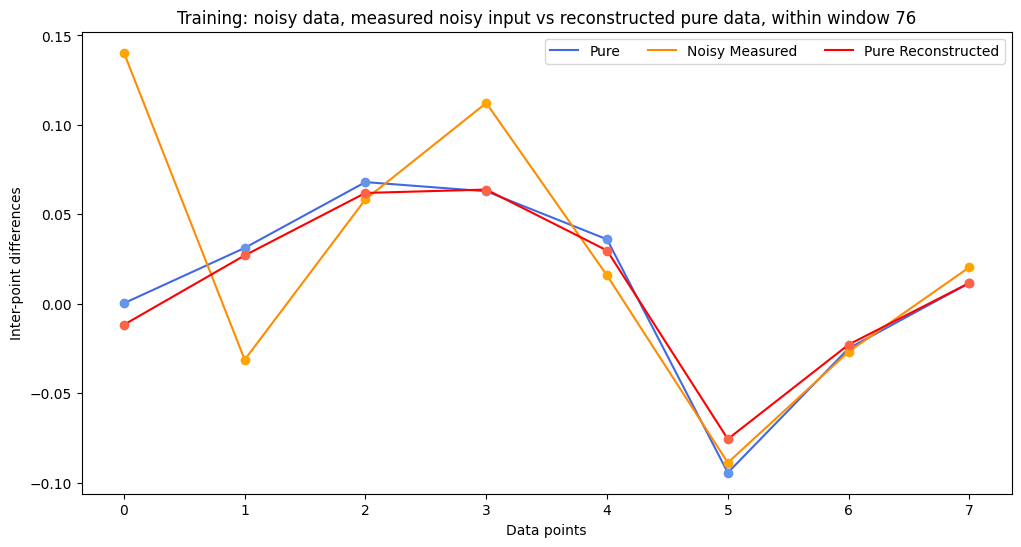

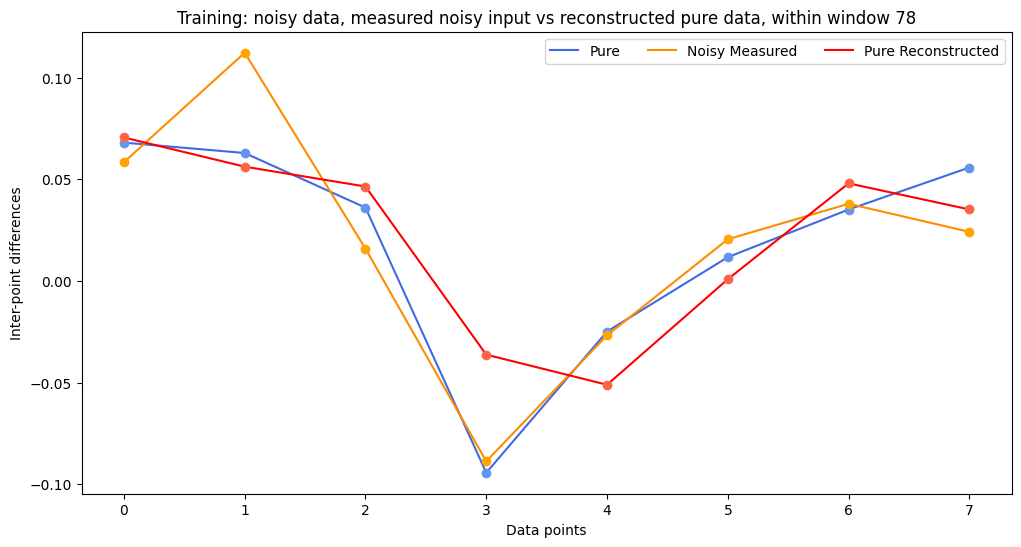

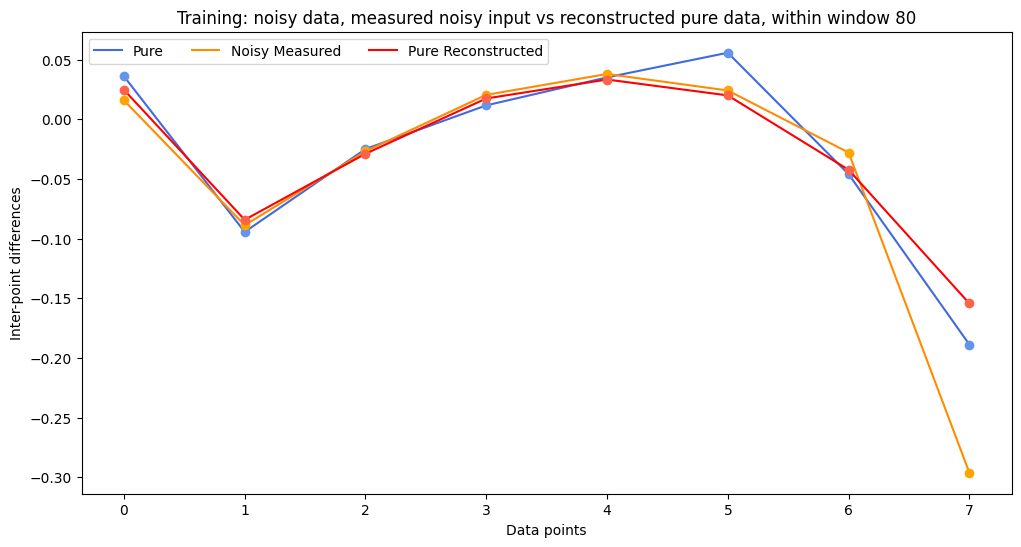

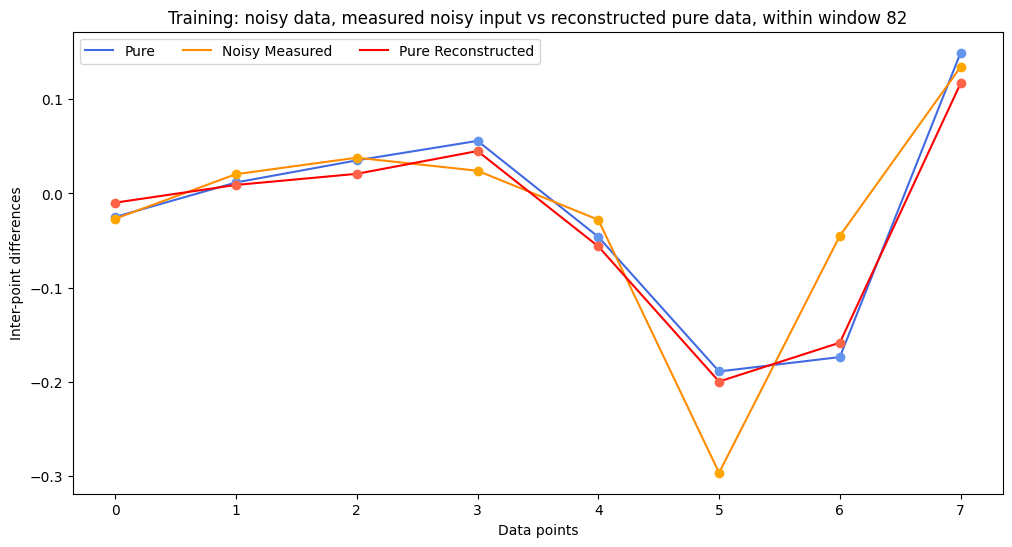

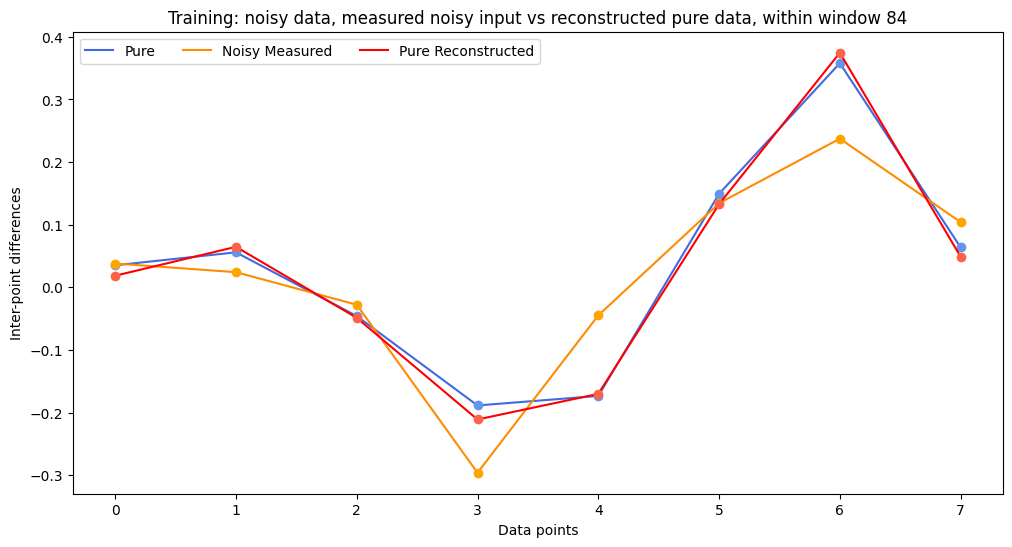

In [39]:
qae_plot_winds(in_org_train_set, in_meas_train_set, out_reconstr_train_set, plot_no=5, 
               title='Training: noisy data, measured noisy input vs reconstructed pure data',
               labels=['Pure', 'Noisy Measured', 'Pure Reconstructed'],
               save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_pt_nt_pt')

#### Plotting results of analysis performed on validation data (not seen by the full-QAE)
The blue line shows pure data that was given on output during training.</br>
The red curve was reconstructed from the noisy data given on input (not shown here).<br/>
The yellow control curve measures the pure data, it follows the blue curve, the best it can.<br/>
The red curve should follow the blue pure data and its variance should not be much different from the yellow lines,<br/>
as it means it has learnt to recover pure data from noise given on input!<br/>
These charts show that the model can generalise away from data shown in training, subject to measurement error.

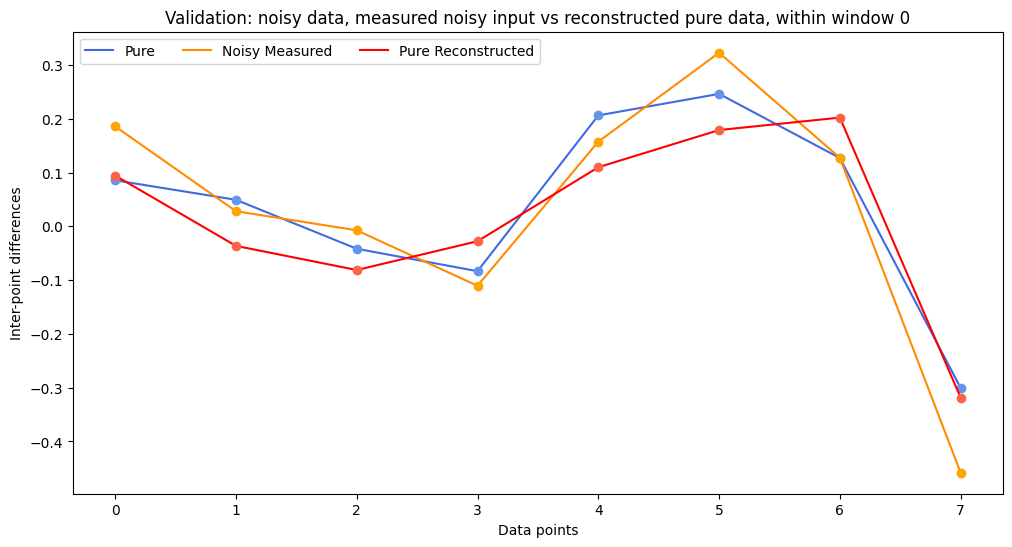

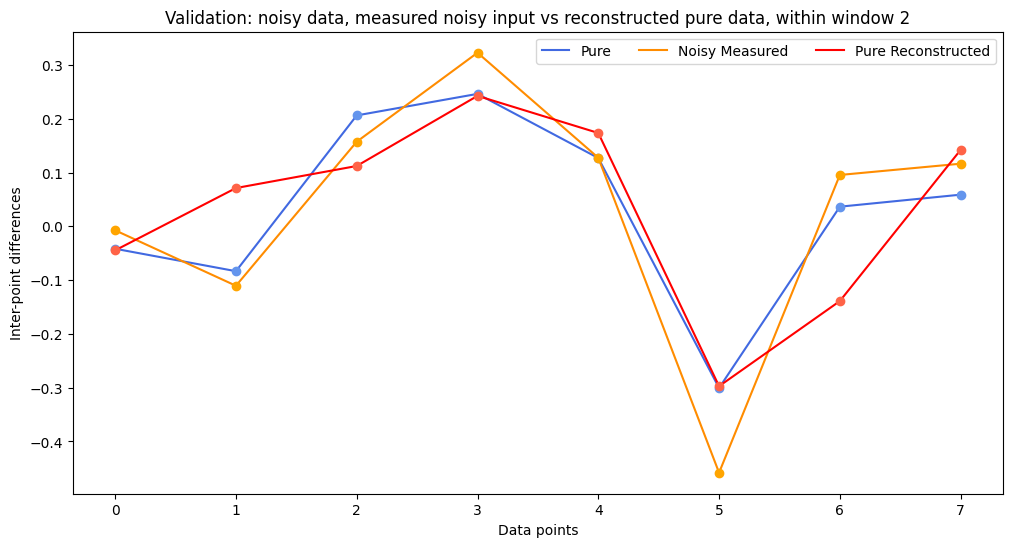

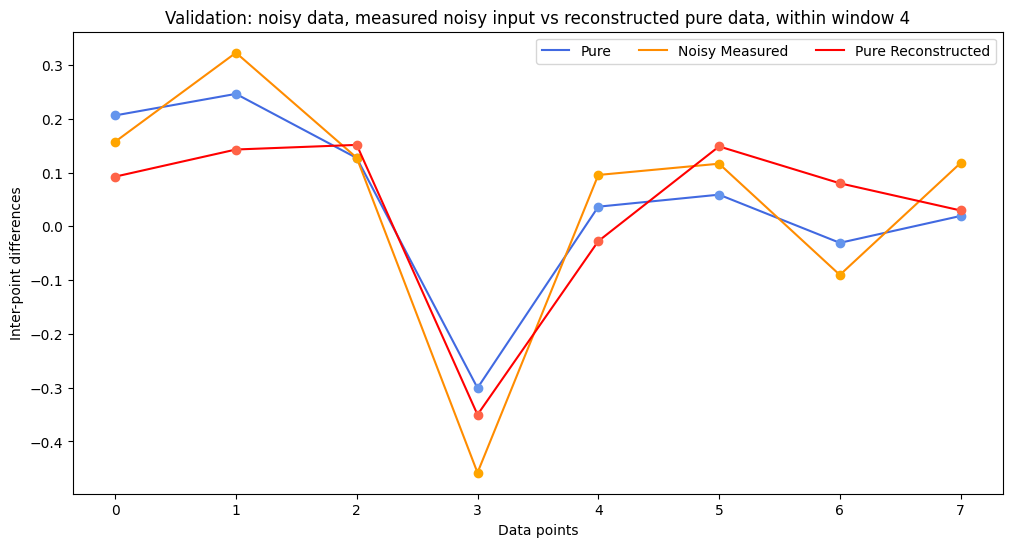

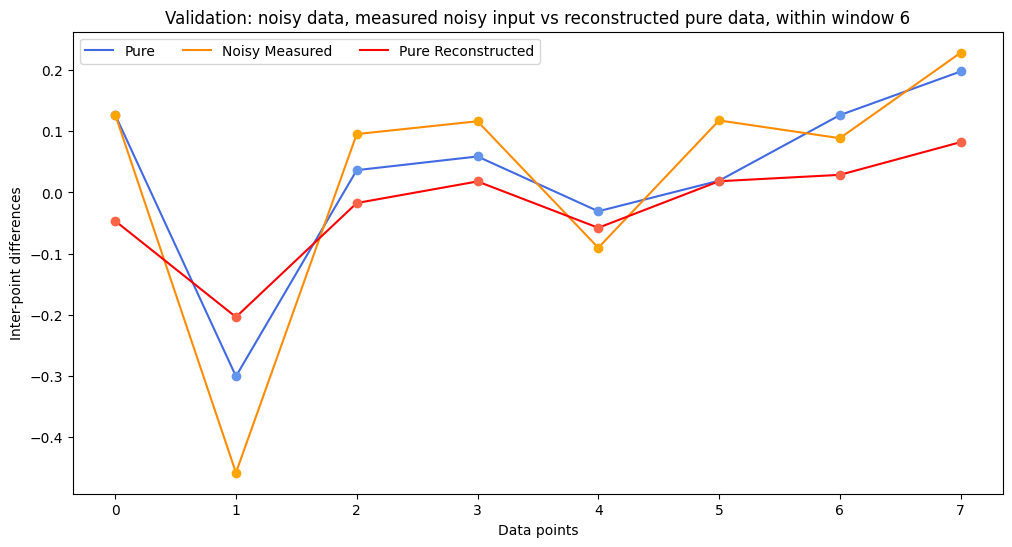

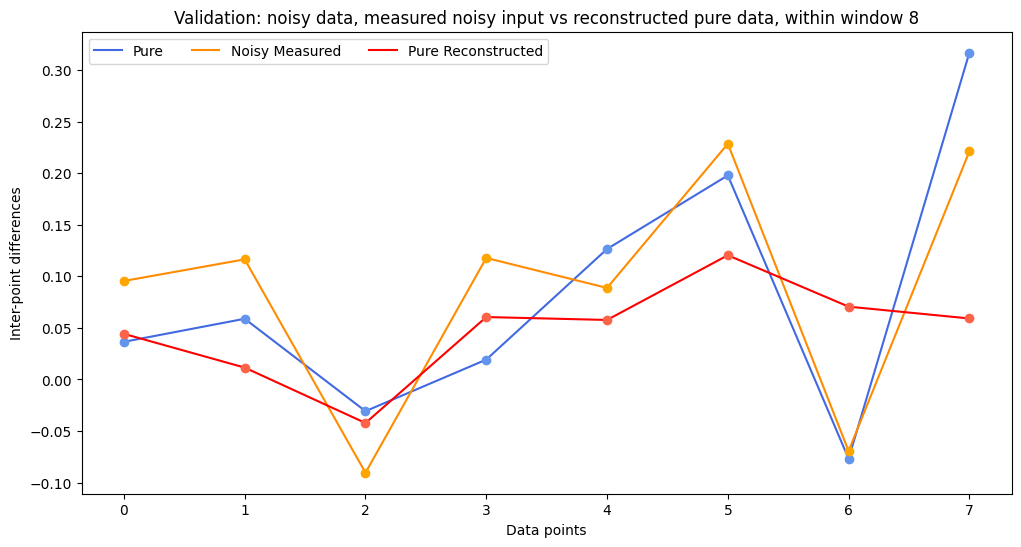

In [40]:
qae_plot_winds(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, plot_no=5,
               title='Validation: noisy data, measured noisy input vs reconstructed pure data',
               labels=['Pure', 'Noisy Measured', 'Pure Reconstructed'],
               save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_pv_nv_pv')

### Accuracy of results after manual removal of edge distortion in a series windows
Based on visual inspection of the QAE results, we can observe that the QAE results are distored at the edges.<br/>
So it is possibe to exclude a few data points from each data window, and hence improve the model accuracy.<br/><br/>
In the left column we have metrics comparing QAE inputs with the same but quantum measured inputs.<br/>
In the right column we have metrics comparing QAE inputs with its outputs - this is what we are intereted in.<br/>
The left column is for your reference to see the impact of measurement on the QAE precision.

In [44]:
### Present some statistics on the sample, after removing the edge distortion
trim_left = 0
trim_right = 2

mae_adj_inorg_train_incalc, mae_adj_inorg_train_outrec = accuracy_report(in_org_train_set, in_meas_train_set, out_reconstr_train_set, 
                title='Train. Acc.', trim_left=trim_left, trim_right=trim_right)
mae_adj_inorg_valid_incalc, mae_adj_inorg_valid_outrec = accuracy_report(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, 
                title='Valid. Acc.', trim_left=trim_left, trim_right=trim_right)
print()


Train. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.887      	0.985     
RMS       	0.084      	0.031     
MAE       	0.066      	0.022     
MAPE      	4.785      	0.561     

Valid. Acc.	Pure vs Noisy	Pure vs Recovered

R2        	0.922      	0.716     
RMS       	0.067      	0.128     
MAE       	0.056      	0.083     
MAPE      	1.132      	0.899     



### Saving the starting point and calculated results

In [45]:
print(f'Files to be saved (when True)\n')
print(f'Original training windows:     {train_inorg_fpath}')
print(f'Measured training windows:     {train_inmeas_fpath}')
print(f'Resulting training windows:    {train_outrec_fpath}\n')
print(f'Original validation windows:   {valid_inorg_fpath}')
print(f'Measured validation windows:   {valid_inmeas_fpath}')
print(f'Resulting validation windows:  {valid_outrec_fpath}\n')

Files to be saved (when True)

Original training windows:     beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_torg.json
Measured training windows:     beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_tinm.json
Resulting training windows:    beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_tout.json

Original validation windows:   beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_vorg.json
Measured validation windows:   beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_vinm.json
Resulting validation windows:  beer_xtest/analysis/2step_torch_n200_w8_ws2_z0.03_zr1_reps0_aw0_none_lat7_vout.json



In [46]:
### Save all calculated data points
to_be_saved_results = True

if to_be_saved_results:
    write_json_file(f'{train_inorg_fpath}', in_org_train_set)
    write_json_file(f'{train_inmeas_fpath}', in_meas_train_set)
    write_json_file(f'{train_outrec_fpath}', out_reconstr_train_set)
    
    write_json_file(f'{valid_inorg_fpath}', in_org_valid_set)
    write_json_file(f'{valid_inmeas_fpath}', in_meas_valid_set)
    write_json_file(f'{valid_outrec_fpath}', out_reconstr_valid_set)
    
    print(f'Saved all calculated windows in: "{ANALYSIS_PATH}" folder')
else:
    print(f'Sample windows not saved') 

Saved all calculated windows in: "beer_xtest/analysis" folder


## Time series integration and plotting
The aim is to merge all windows produced in testing into a single sequence, stored as a dictionary. As depicted in the following figure, the integration procedure needs to average all overalapping windows values (white boxes), while considering the step between windows (which creates gaps between overlapping windows) and their edge trimming (which removes distorted values, indicated as gray boxes). 

<div>
    <!--img src="attachment:wind-integration.png" width="1000"-->
    <img src="../images/wind-integration.png" width="1000">
</div>

**Figure: Windows integration procedure**

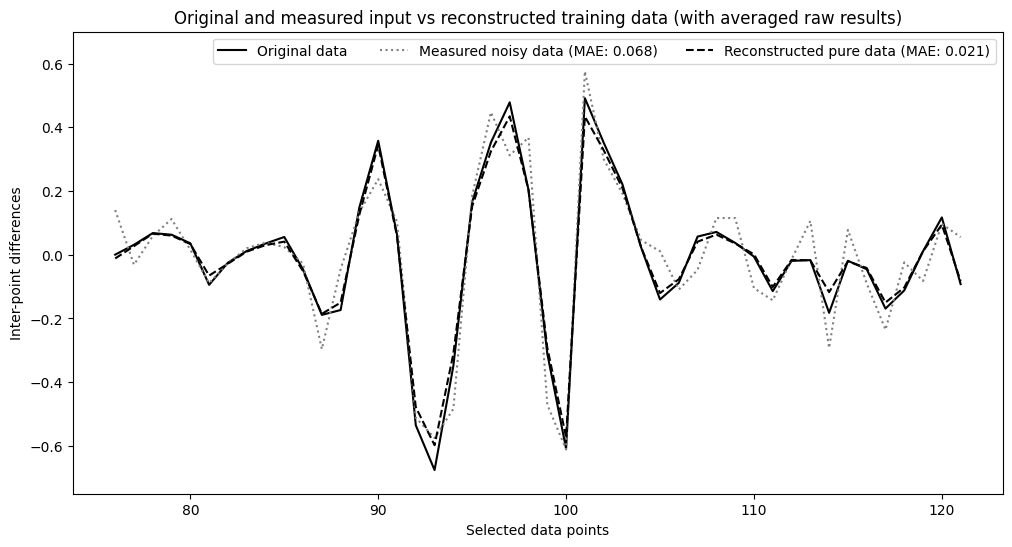

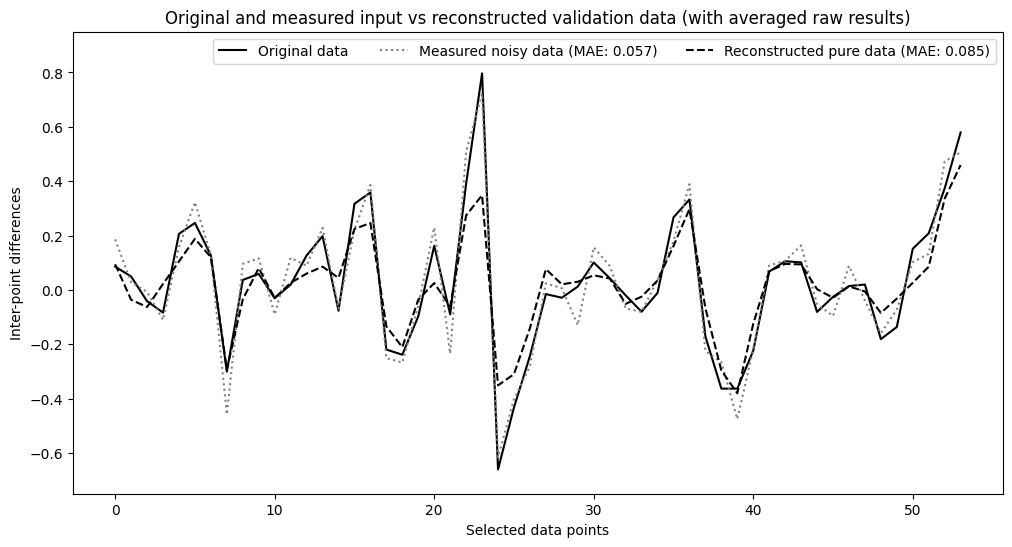

In [55]:
# Plot all raw results
in_org_train_seq, in_meas_train_seq, out_recons_train_seq = qae_winds_integ(in_org_train_set, in_meas_train_set, out_reconstr_train_set)
qae_seq_plot(in_org_train_seq, in_meas_train_seq, out_recons_train_seq, title=f'Original and measured input vs reconstructed training data (with averaged raw results)',
             labels=['Original data', 'Measured noisy data', 'Reconstructed pure data'],
             label_suffix=[f'', f'(MAE: {np.round(mae_inorg_train_incalc, 3)})', f'(MAE: {np.round(mae_inorg_train_outrec, 3)})'], ylim=(-0.75,0.7),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_inttra_org_bw.eps',
             line_styles=['solid', 'dotted', 'dashed'], marker_line_style='None',
             line_cols=['black', 'gray', 'black'])

in_org_valid_seq, in_meas_valid_seq, out_recons_valid_seq = qae_winds_integ(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set)
qae_seq_plot(in_org_valid_seq, in_meas_valid_seq, out_recons_valid_seq, title=f'Original and measured input vs reconstructed validation data (with averaged raw results)',
             labels=['Original data', 'Measured noisy data', 'Reconstructed pure data'],
             label_suffix=[f'', f'(MAE: {np.round(mae_inorg_valid_incalc, 3)})', f'(MAE: {np.round(mae_inorg_valid_outrec, 3)})'], ylim=(-0.75,0.95),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_intval_org_bw.eps',
             line_styles=['solid', 'dotted', 'dashed'], marker_line_style='None',
             line_cols=['black', 'gray', 'black'])

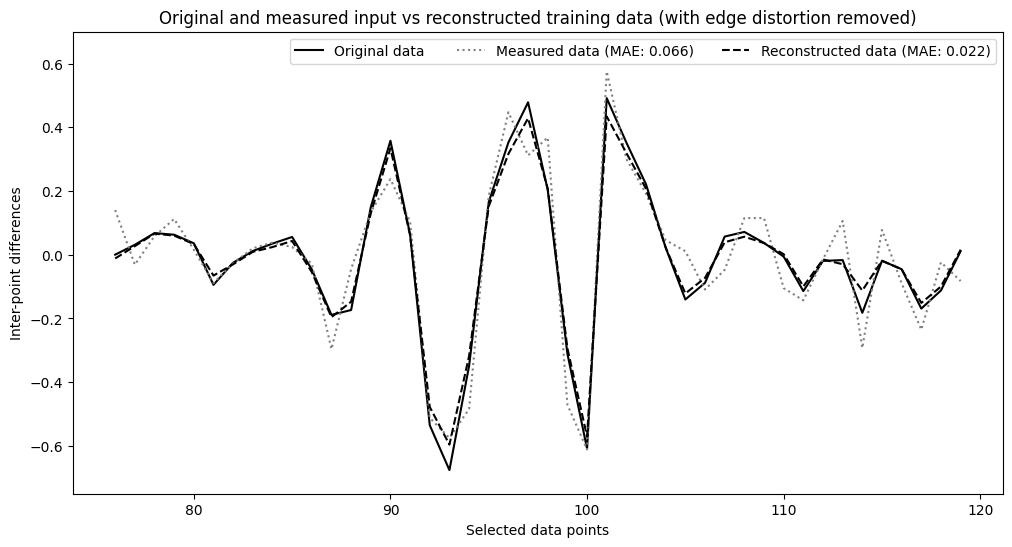

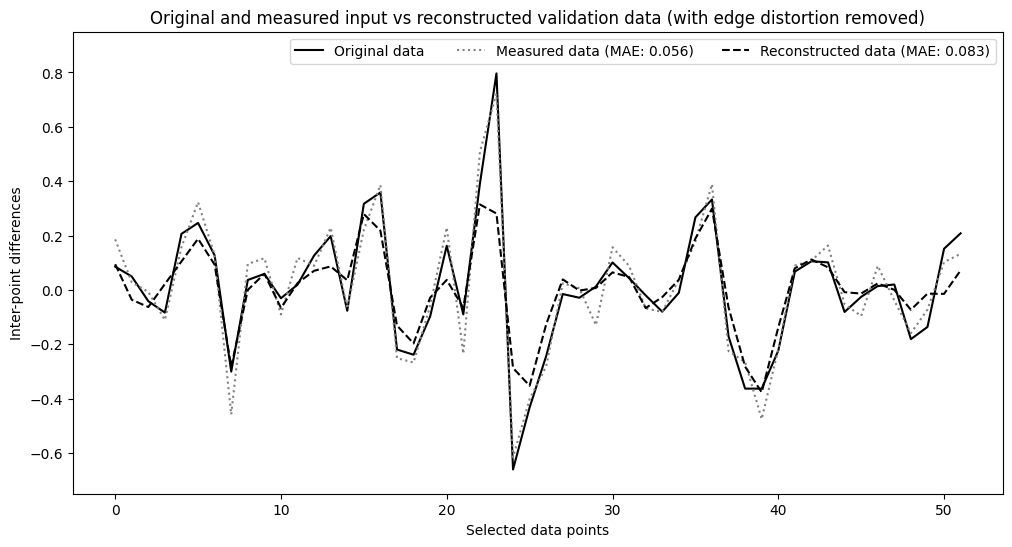

In [56]:
# Plot all results with distortion trimming
in_org_adj_train_seq, in_meas_adj_train_seq, out_recons_adj_train_seq = qae_winds_integ(in_org_train_set, in_meas_train_set, out_reconstr_train_set, trim_left, trim_right)
qae_seq_plot(in_org_adj_train_seq, in_meas_adj_train_seq, out_recons_adj_train_seq, title=f'Original and measured input vs reconstructed training data (with edge distortion removed)',
             label_suffix=[f'', f'(MAE: {np.round(mae_adj_inorg_train_incalc, 3)})', f'(MAE: {np.round(mae_adj_inorg_train_outrec, 3)})'], ylim=(-0.75, 0.7),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_inttra_adj_bw.eps',
             line_styles=['solid', 'dotted', 'dashed'], marker_line_style='None',
             line_cols=['black', 'gray', 'black'])

in_org_adj_valid_seq, in_meas_adj_valid_seq, out_recons_adj_valid_seq = qae_winds_integ(in_org_valid_set, in_meas_valid_set, out_reconstr_valid_set, trim_left, trim_right)
qae_seq_plot(in_org_adj_valid_seq, in_meas_adj_valid_seq, out_recons_adj_valid_seq, title=f'Original and measured input vs reconstructed validation data (with edge distortion removed)',
             label_suffix=[f'', f'(MAE: {np.round(mae_adj_inorg_valid_incalc, 3)})', f'(MAE: {np.round(mae_adj_inorg_valid_outrec, 3)})'], ylim=(-0.75, 0.95),
             save_plot=f'{FIGURES_PATH}/{TRAIN_PREF}_intval_adj_bw.eps',
             line_styles=['solid', 'dotted', 'dashed'], marker_line_style='None',
             line_cols=['black', 'gray', 'black'])

## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

## Performance Statistics
The format of the presented statistics was evolving over time. In the current edition, which is most evident in the reporting for the experiments running on the "furies-vengence" machine, the reported details include:
- device: Device used to accelerate computation (GPU/CPU)
- samples: Number of samples used in training (numeric)
- reps: Number of repeated blocks in ansatz (numeric)
- ent: Entaglement type (linear, reverse_linear, full, circular, sca, pairwise)
- qubits l+t: Number of core ansatz qubits used in QAE testing (numeric latent + trash qubits)
- params: Number of trainable parameters (numeric)
- epoch: Number of training iterations (numeric)
- min cost: Minimum cost achieved in circuit optimisation (numeric)
- sec: Elapsed time in seconds used in circuit training (numeric)
- R2: R squared providing goodness of fit between the TS window and its reconstruction (0..1)
- Trim l+r: R2 measure between windows trimmed to deal with edge distortion (numeric left + right)
- comment: Additional remark on the experiment's success (e.g. "Promissing" or "Disappointing")
- colour: Colour siginfying the "goodness" of selected experiment's controls (blue=great, red=terrible, magenta=note this, black=FYI)

# Software in use

In [57]:
!pip list | grep -E 'qiskit|torch'

qiskit                    0.46.0
qiskit-aer                0.13.3
qiskit-algorithms         0.2.2
qiskit-machine-learning   0.7.1
qiskit-terra              0.46.0
torch                     2.3.0
torchaudio                2.3.0
torchvision               0.18.0
